In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [2]:
!cp -r /kaggle/input/causal-digital-marketing-campaign-dataset/* ./

In [3]:
df=pd.read_excel('/kaggle/working/Dataset.xlsx')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            5000 non-null   int64  
 1   campaign_id        5000 non-null   object 
 2   channel            5000 non-null   object 
 3   device             5000 non-null   object 
 4   country            5000 non-null   object 
 5   segment            5000 non-null   object 
 6   prior_visits_30d   5000 non-null   int64  
 7   prior_spend_180d   5000 non-null   float64
 8   treatment_exposed  5000 non-null   int64  
 9   impressions        5000 non-null   int64  
 10  clicks             5000 non-null   int64  
 11  spend_usd          5000 non-null   float64
 12  conversion         5000 non-null   int64  
 13  revenue_usd        5000 non-null   float64
 14  roi                5000 non-null   float64
dtypes: float64(4), int64(6), object(5)
memory usage: 586.1+ KB


In [5]:
cols_drop = ['user_id', 'campaign_id', 'impressions', 'clicks', 'spend_usd', 'revenue_usd', 'roi']

In [6]:
df_clean=df.drop(cols_drop,axis =1)

In [7]:
one_hot_cols=['channel','device','country','segment']
df_onehot=pd.get_dummies(df_clean,columns=one_hot_cols,drop_first=True)
df_onehot.head()

,prior_visits_30d,prior_spend_180d,treatment_exposed,conversion,channel_Email,channel_Search,channel_Social,channel_Video,device_Mobile,device_Tablet,country_DE,country_FR,country_IN,country_UK,country_US,segment_Food,segment_Health,segment_Outdoor,segment_Tech
0,3,93.14,0,0,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
1,0,55.14,0,0,False,False,True,False,True,False,False,False,True,False,False,True,False,False,False
2,4,278.79,0,0,False,True,False,False,True,False,False,True,False,False,False,False,False,False,True
3,2,292.60,1,0,False,True,False,False,False,True,False,False,True,False,False,True,False,False,False
4,4,16.98,0,0,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True


In [8]:
df_train, df_test = train_test_split(df_onehot,random_state=42)
x_train=df_train.drop(['conversion'],axis =1)
y_train=df_train['conversion']
x_test=df_test.drop(['conversion'],axis =1)
y_test=df_test['conversion']
w_train=df_train['treatment_exposed']
w_test=df_test['treatment_exposed']

In [9]:
x_train_treat=x_train[w_train ==1]
y_train_treat=y_train[w_train==1]

In [10]:
x_train_cont=x_train[w_train ==0]
y_train_cont=y_train[w_train==0]

In [11]:
model_treatment = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model_control   = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

In [12]:
model_treatment.fit(x_train_treat,y_train_treat)

RandomForestClassifier(max_depth=10, random_state=42)

In [13]:
model_control.fit(x_train_cont,y_train_cont)

RandomForestClassifier(max_depth=10, random_state=42)

In [14]:
pred_treat = model_treatment.predict_proba(x_test)[:, 1]
pred_treat

array([0.11558121, 0.04261433, 0.12382225, ..., 0.04018392, 0.09165286,
       0.1530909 ])

In [15]:
pred_control = model_control.predict_proba(x_test)[:, 1]
pred_control

array([0.0922013 , 0.06422618, 0.0550585 , ..., 0.07366056, 0.04460233,
       0.17853328])

In [16]:
uplift_score = pred_treat - pred_control

In [17]:
df_results = pd.DataFrame({
    'User_ID': df.loc[x_test.index, 'user_id'] if 'user_id' in df.columns else x_test.index, # Lấy ID nếu có
    'Uplift_Score': uplift_score,
    'Prob_Buy_Ad': pred_treat,
    'Prob_Buy_NoAd': pred_control,
    'Real_Outcome': y_test,   # Thực tế họ có mua không
    'Real_Treatment': w_test  # Thực tế họ thuộc nhóm nào
})

In [18]:
df_results[df_results['Real_Outcome']==1]

,User_ID,Uplift_Score,Prob_Buy_Ad,Prob_Buy_NoAd,Real_Outcome,Real_Treatment
106,633556,0.066586,0.224884,0.158298,1,0
915,904449,0.212663,0.287518,0.074855,1,0
2515,983084,0.026558,0.147085,0.120527,1,1
2099,462130,0.271879,0.372841,0.100962,1,0
2659,529667,0.004433,0.078665,0.074233,1,1
...,...,...,...,...,...,...
1162,962557,0.023951,0.082681,0.058730,1,1
3639,650458,0.065996,0.173086,0.107090,1,0
3265,731827,0.027541,0.100384,0.072843,1,0
14,291335,0.159203,0.228167,0.068964,1,1


In [19]:
df_results = df_results.sort_values(by='Uplift_Score', ascending=False)
df_results

,User_ID,Uplift_Score,Prob_Buy_Ad,Prob_Buy_NoAd,Real_Outcome,Real_Treatment
3814,688595,0.388576,0.436173,0.047597,0,1
1061,998860,0.386344,0.468540,0.082196,0,0
4257,191088,0.368142,0.525635,0.157493,1,0
297,758271,0.352647,0.399852,0.047205,0,1
1739,137641,0.339956,0.386338,0.046382,0,0
...,...,...,...,...,...,...
4434,378710,-0.158354,0.086864,0.245217,0,0
287,115708,-0.174957,0.155893,0.330850,0,1
2480,530424,-0.194941,0.078600,0.273541,0,1
1962,590042,-0.207551,0.064378,0.271930,0,0


In [20]:
y_pred_treat=model_treatment.predict(x_test)
acc_treat=accuracy_score(y_test,y_pred_treat)
print('Accuracy score of Treatment model:',acc_treat)

Accuracy score of Treatment model: 0.896


In [21]:
y_pred_control=model_control.predict(x_test)
acc_control=accuracy_score(y_test,y_pred_control)
print('Accuracy score of Control model:',acc_control)

Accuracy score of Control model: 0.8952


Top 10 features quan trọng nhất - Treatment model
             feature  importance
1   prior_spend_180d    0.401644
0   prior_visits_30d    0.171271
7      device_Mobile    0.046106
4     channel_Search    0.033419
16   segment_Outdoor    0.032556
14      segment_Food    0.032156
17      segment_Tech    0.031670
5     channel_Social    0.030913
15    segment_Health    0.027097
8      device_Tablet    0.026871
Top 10 features quan trọng nhất - Control model
             feature  importance
1   prior_spend_180d    0.456287
0   prior_visits_30d    0.139703
7      device_Mobile    0.044725
5     channel_Social    0.031284
14      segment_Food    0.030566
17      segment_Tech    0.029087
10        country_FR    0.029063
15    segment_Health    0.028499
4     channel_Search    0.027138
16   segment_Outdoor    0.026984


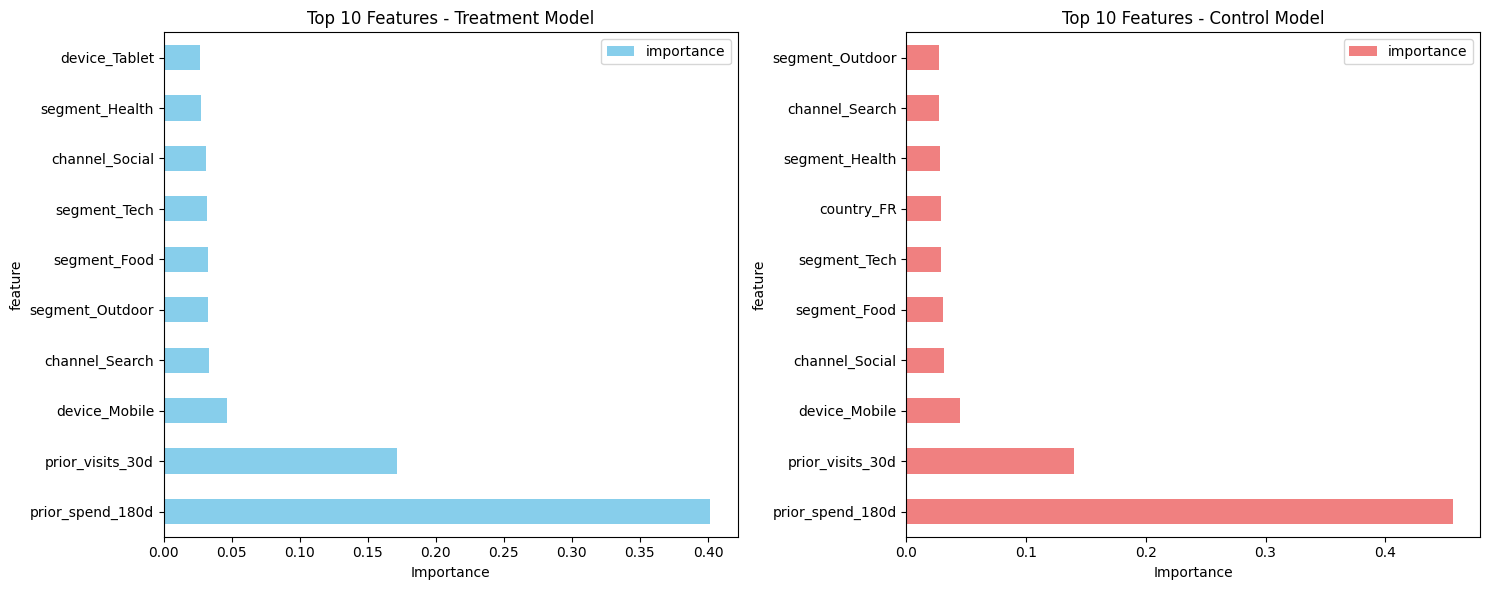

In [22]:
feature_importance_treat = pd.DataFrame({
    'feature': x_train.columns,
    'importance': model_treatment.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance_control = pd.DataFrame({
    'feature': x_train.columns,
    'importance': model_control.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 features quan trọng nhất - Treatment model")
print(feature_importance_treat.head(10))

print("Top 10 features quan trọng nhất - Control model")
print(feature_importance_control.head(10))

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

feature_importance_treat.head(10).plot(x='feature', y='importance', kind='barh', ax=axes[0], color='skyblue')
axes[0].set_title('Top 10 Features - Treatment Model')
axes[0].set_xlabel('Importance')

feature_importance_control.head(10).plot(x='feature', y='importance', kind='barh', ax=axes[1], color='lightcoral')
axes[1].set_title('Top 10 Features - Control Model')
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.show()


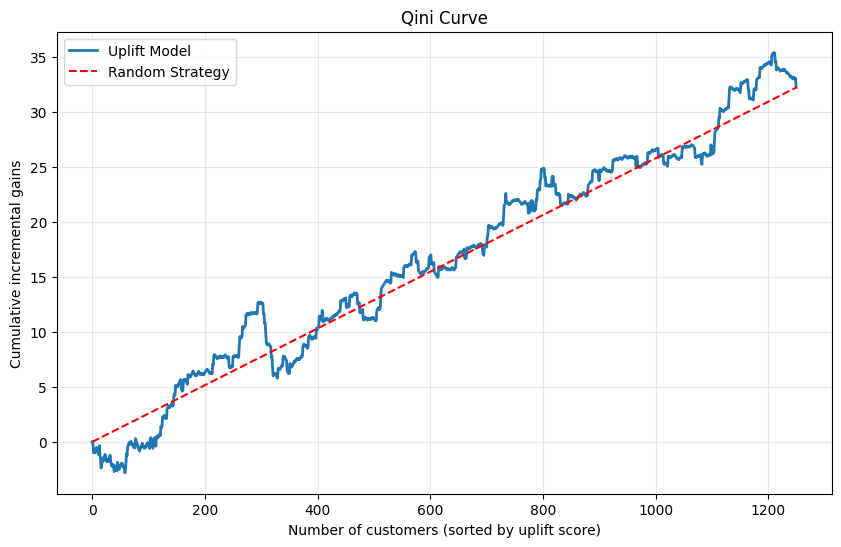

AUUC score: 20,724


In [30]:
qini_df = pd.DataFrame({'y': y_test, 'w': w_test, 'uplift': uplift_score}).sort_values(by='uplift', ascending=False).reset_index(drop=True)
qini_df['cum_y_treat'] = (qini_df['y'] * qini_df['w']).cumsum()
qini_df['cum_n_treat'] = qini_df['w'].cumsum()
qini_df['cum_y_ctrl'] = (qini_df['y'] * (1 - qini_df['w'])).cumsum()
qini_df['cum_n_ctrl'] = (1 - qini_df['w']).cumsum().replace(0, 1)
qini_df['qini'] = qini_df['cum_y_treat'] - (qini_df['cum_y_ctrl'] * qini_df['cum_n_treat'] / qini_df['cum_n_ctrl'])
plt.figure(figsize=(10, 6))
x_axis = np.arange(len(qini_df))
plt.plot(x_axis, qini_df['qini'], label='Uplift Model', linewidth=2)
final_qini = qini_df['qini'].iloc[-1]
plt.plot([0, len(qini_df)], [0, final_qini], 'r--', label='Random Strategy')
plt.xlabel('Number of customers (sorted by uplift score)')
plt.ylabel('Cumulative incremental gains')
plt.title('Qini Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
auuc_score = np.trapz(qini_df['qini'], x_axis)
print(f"AUUC score: {auuc_score:,.0f}")

In [31]:
uplift_positive = (
    df_results[df_results["Uplift_Score"] > 0]
        .sort_values("Uplift_Score", ascending=False)
)
top_10pct = df_results.nlargest(int(len(df_results) * 0.10), "Uplift_Score")
summary_stats = {
    "Total Customers": len(df_results),
    "Customers with Positive Uplift": (df_results["Uplift_Score"] > 0).sum(),
    "Average Uplift Score": df_results["Uplift_Score"].mean(),
    "Median Uplift Score": df_results["Uplift_Score"].median(),
    "Max Uplift Score": df_results["Uplift_Score"].max(),
    "Min Uplift Score": df_results["Uplift_Score"].min(),
    "Treatment Model Accuracy": acc_treat,
    "Control Model Accuracy": acc_control,
    "AUUC Score": auuc_score,
}

In [33]:
df_results.to_csv("uplift_results_all.csv", index=False)

uplift_positive.to_csv("uplift_top_targets.csv", index=False)
top_10pct.to_csv("uplift_top_10_percent.csv", index=False)
pd.DataFrame([summary_stats]).to_csv("uplift_summary_stats.csv", index=False)
